# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import imageio    #mageio is a Python library that provides an easy interface to read and write a wide range of image data, including animated images, volumetric data, and scientific formats. 

In [2]:
from imageio import imread,imwrite,imsave

In [3]:
import numpy as np
import os
# from scipy.misc import imread, imresize
import datetime
import random
from matplotlib import pyplot as plt

In [4]:
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
batch_size = 50 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
                    print("Batch: ",num_batches+1,"Index:", batch_size)
                    batch_size = len(folder_list) - (batch_size*num_batches)
                    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                    for folder in range(batch_size): # iterate over the batch_size
                        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                            #crop the images and resize them. Note that the images are of 2 different shape 
                            #and the conv3D will throw error if the inputs in a batch have different shapes
                            temp = resize(image,(120,120))
                            temp = temp/127.5-1 #Normalize data

                            batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                            batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                            batch_data[folder,idx,:,:,2] = (temp[:,:,2])

                        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

* Resize the image in such that all image is scaled (120*120).

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/notebooks/storage/Final_data/Collated_training/train'
val_path = '/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from keras.layers import Dropout

#write your model here

model = Sequential()

model.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, #Number pf filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


* We increase 1000 neurons in fully connected layers(dense layer) with relu activation and also increase 50% dropout means to reduce overfitting. Out of 1000 layer 500 layer is droped in such a way that mostly contain local minima.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)   

* Begin Conv3D with minimum number of filters as 8. 
* After that we done batch normalization because it will standardize the learning process and dramatically reducing the number of training epochs required to train deep networks. 
* And thought of using activation relu because to overcome vanishing gradient & to give output into 0 to +ve infinite number.
* Then max_pooling to get maximum important feature & reduce the size of image

* Use metric as categorical_accuracy in which it finds the probability of a feature belonging for the particular category find the probability which has highest probability & loss as Cross entropy which is a loss function that is used to quantify the difference between two probability distributions.
* We used Adam optimization which is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. So that it provides an optimization algorithm that can handle sparse gradients on noisy problems


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5py'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path = Source path =  C:\Users\abhis\Ankit\Gesture Recognition Project\Project\val ; batch size = 50
 C:\Users\abhis\Ankit\Gesture Recognition Project\Project\train ; batch size = 50
Epoch 1/50
14/14 [==============================] - 427s 30s/step - loss: 4.4999 - categorical_accuracy: 0.2172 - val_loss: 1.4863 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-02-0610_10_55.511498/model-00001-4.66714-0.21719-1.48634-0.23000.h5py
Epoch 2/50
14/14 [==============================] - 122s 9s/step - loss: 1.7478 - categorical_accuracy: 0.2857 - val_loss: 1.5803 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2021-02-0610_10_55.511498/model-00002-1.74776-0.28571-1.58029-0.23000.h5py
Epoch 3/50
14/14 [==============================] - 121s 9s/step - loss: 1.3686 - categorical_accuracy: 0.4286 - val_loss: 1.3664 - val_categorical_accuracy: 0.3200

Epoch 00003: saving model to model_init_2021-02-0610_10_55.511498/model-00003-1.

14/14 [==============================] - 119s 9s/step - loss: 0.7212 - categorical_accuracy: 0.7418 - val_loss: 0.8131 - val_categorical_accuracy: 0.7100

Epoch 00026: saving model to model_init_2021-02-0610_10_55.511498/model-00026-0.72120-0.74176-0.81314-0.71000.h5py
Epoch 27/50
14/14 [==============================] - 120s 9s/step - loss: 0.5963 - categorical_accuracy: 0.7692 - val_loss: 0.7548 - val_categorical_accuracy: 0.7200

Epoch 00027: saving model to model_init_2021-02-0610_10_55.511498/model-00027-0.59627-0.76923-0.75476-0.72000.h5py
Epoch 28/50
14/14 [==============================] - 119s 9s/step - loss: 0.6530 - categorical_accuracy: 0.7473 - val_loss: 0.7691 - val_categorical_accuracy: 0.7200

Epoch 00028: saving model to model_init_2021-02-0610_10_55.511498/model-00028-0.65301-0.74725-0.76910-0.72000.h5py
Epoch 29/50
14/14 [==============================] - 119s 9s/step - loss: 0.5657 - categorical_accuracy: 0.7967 - val_loss: 0.6170 - val_categorical_accuracy: 0.7300


* Accuracy acheived 81%

In [17]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    


    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

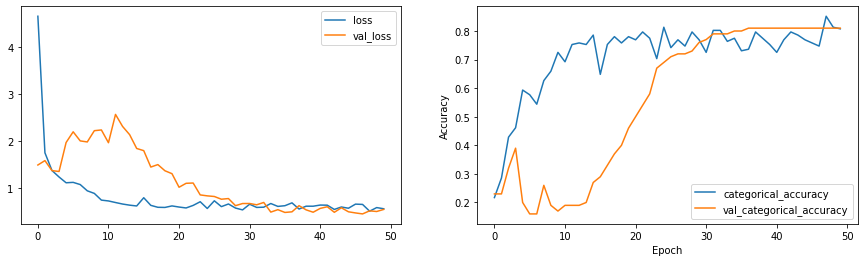

In [18]:
plot(history)

* Clearly graph shows no overfitting which avoid local minima and loss is reduced. Categorical accuracy and valdiation categorical accuracy is also increase and equal which say model is good  

### Model 2: 2D Conv + RNN (Transfer Learning using MobileNet)

In [121]:
batch_size = 10
num_epochs = 25
x = 30 # # x is the number of images
y = 120 # width of the image
z = 120 # height of the image
classes = 5 #5 gestures 
channel = 3 #RGB

In [122]:
from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)     #In Deep Convolutional Neural Network imagenet was able to classify 1.3 million high-resolution images into 1000 different classes
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

C:\Users\abhis\Anaconda3\envs\ankit\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [168]:
model = Sequential()
model.add(TimeDistributed(pretrained_mobilenet,input_shape=(x,y,z,channel)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add( LSTM( 32))
model.add(Dropout(0.25))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

* We have use MobileNet because to use depthwise separable convolutions to build lighter deep neural networks.

In [170]:
train_generator6 = generator(train_path, train_doc, batch_size)
val_generator6 = generator(val_path, val_doc, batch_size)

In [171]:
optimiser = optimizers.Adam(lr=0.0001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_73 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_74 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_75 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_76 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                135296    
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)              

* time distribution with 4 layer and use LSTM to avoid exploding and vanishing gradient with 32 units and use 2 dense layer (fully connected layer) and 25% layer is drop out to avoid overfitting 

In [172]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5py'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [173]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [174]:
history6 = model.fit_generator(train_generator6, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator6, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:\Users\abhis\Ankit\Gesture Recognition Project\Project\train ; batch size = 10
Source path =  C:\Users\abhis\Ankit\Gesture Recognition Project\Project\val ; batch size = 10
Epoch 1/25
67/67 [==============================] - 1063s 16s/step - loss: 1.6003 - categorical_accuracy: 0.2428 - val_loss: 1.4434 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2021-02-0611_55_59.820448/model-00001-1.60150-0.24284-1.44339-0.29000.h5py
Epoch 2/25
67/67 [==============================] - 353s 5s/step - loss: 1.4316 - categorical_accuracy: 0.3731 - val_loss: 1.4862 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2021-02-0611_55_59.820448/model-00002-1.43155-0.37313-1.48617-0.46000.h5py
Epoch 3/25
67/67 [==============================] - 362s 5s/step - loss: 1.3124 - categorical_accuracy: 0.4627 - val_loss: 1.3230 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to model_init_2021-02-0611_55_59.820448/model-00003-1.

* Accuracy acheived 87%

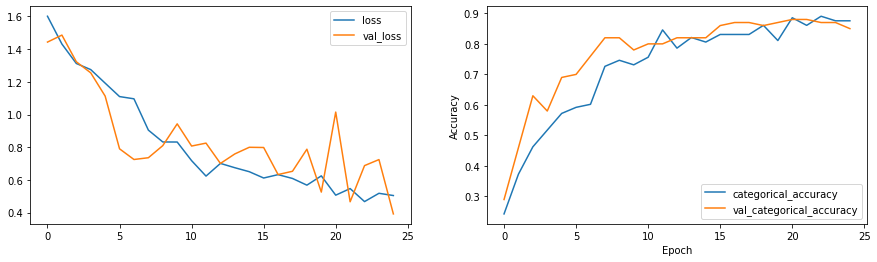

In [175]:
plot(history6)

* Clearly graph shows no overfitting which avoid local minima and loss is reduced. Categorical accuracy and valdiation categorical accuracy is also increase and equal which say model is very good  

* With 25 epoch and 25% dropout : loss and validation loss is minimum at the end 